<h3>Implementing Deep Neural Network from scratch</h3>

In [280]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import math


def softmax(z):
    z -= np.max(z, axis=1, keepdims=True)
    ans = np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    return ans


def relu(z):
    z[z < 0] = 0
    return z


def relu_prime(z):
    z[z <= 0] = 0
    z[z > 0] = 1
    return z


# Just for the sake of saving  computing time to recalculate y_hat in each mini_batch
def stochastic_J(w1, w2, y_hat, images, labels, alpha=0.):
    x = images
    y = labels
    m = x.shape[0]
    cost_mat = np.multiply(y, np.log(y_hat))
    cost = (-1. / m) * np.sum(np.sum(cost_mat, axis=1))
    # Regularize
    cost += (alpha/(2 * m)) * (np.linalg.norm(w1) + np.linalg.norm(w2))
    return cost


def J(w1, w2, b1, b2, images, labels, alpha=0.):
    x = images
    y = labels
    m = x.shape[0]
    h1, y_hat = feedforward(w1, w2, b1, b2, x, y)
    cost_mat = np.multiply(y, np.log(y_hat))
    cost = (-1. / m) * np.sum(np.sum(cost_mat, axis=1))
    # Regularize
    cost += (alpha/(2 * m)) * (np.linalg.norm(w1) + np.linalg.norm(w2))
    return cost


def feedforward(w1, w2, b1, b2, images, labels):
    x = images
    h1 = relu(x.dot(w1.T) + b1)
    y_hat = softmax(h1.dot(w2.T) + b2)
    return h1, y_hat


def grad_layer2(h1, y_hat, w1, w2, images, labels, alpha=0.):
    y = labels
    m = y.shape[0]
    dJ_dz2 = (y_hat - y)/m
    dJ_dw2 = dJ_dz2.T.dot(h1)
    #Regularize
    dJ_dw2 += (alpha/m) * w2
    dJ_b2 = np.sum(dJ_dz2, axis=0, keepdims=True)
    return dJ_dw2, dJ_b2


def grad_layer1(h1, y_hat, w1, w2, images, labels, alpha=0.):
    x = images
    y = labels
    m = y.shape[0]
    dJ_dz2 = (y_hat - y)/m
    dJ_dh1 = dJ_dz2.dot(w2)
    g = dJ_dh1 * relu_prime(x.dot(w1.T))  # dJ/dz1
    dJ_dw1 = g.T.dot(x)
    # Regularize
    dJ_dw1 += (alpha/m) * w1
    dJ_db1 = np.sum(g, axis=0, keepdims=True)
    return dJ_dw1, dJ_db1


def sgd(train_images, train_labels, val_images, val_labels, h_nodes, epsilon, batch_size, epochs, alpha=0., searching=False):
    x = train_images
    y = train_labels
    sample_size, dimensions = x.shape
    classes = y.shape[1]
    cost_history = np.array([])

    w1_range = math.sqrt(1./dimensions)
    w1 = np.random.uniform(-w1_range, w1_range, (h_nodes, dimensions))
    b1 = np.ones((1, h_nodes)) * 0.1
    w2_range = math.sqrt(1./h_nodes)
    w2 = np.random.uniform(-w2_range, w2_range, (classes, h_nodes))
    b2 = np.ones((1, classes)) * 0.1

    num_batches = sample_size / batch_size
    for e in xrange(epochs):
        batch_history = np.array([])

        x_y = np.append(x, y, axis=1)
        np.random.shuffle(x_y)
        x_s = x_y[:, :dimensions]
        y_s = x_y[:, dimensions:]
        for i in xrange(num_batches):
            start = i * batch_size
            end = start + batch_size
            x_batch = x_s[start:end]
            y_batch = y_s[start:end]
            # Do feedforward pass
            h1, y_hat = feedforward(w1, w2, b1, b2, x_batch, y_batch)
            # Find dJ/dw1 and dJ/d1
            gradw1, gradb1 = grad_layer1(h1, y_hat, w1, w2, x_batch, y_batch, alpha)
            # Find dJ/dw2 and dJ/dwb2
            gradw2, gradb2 = grad_layer2(h1, y_hat, w1, w2, x_batch, y_batch, alpha)
            w1 -= (epsilon * gradw1)
            b1 -= (epsilon * gradb1)
            w2 -= (epsilon * gradw2)
            b2 -= (epsilon * gradb2)
            # Cost of current mini-batch
            cost = stochastic_J(w1, w2, y_hat, x_batch, y_batch, alpha)
            # List of costs for all the mini-batches in current epoch
            batch_history = np.append(batch_history, cost)

        epoch_cost = np.mean(batch_history)
        # List of costs for epochs
        cost_history = np.append(cost_history, epoch_cost)
        # Accuracy of on validation data set after each epoch
        validation_acc = report_accuracy(w1, w2, b1, b2, val_images, val_labels)
        if e % 2 == 0:
            print("Epochs: %d Cost: %.5f Validation Acc: %.2f ||w1||: %.5f ||w2||: %.5f" % (
                e, epoch_cost, validation_acc, np.linalg.norm(w1), np.linalg.norm(w2)))

    if searching:
        # When searching best hyperparameters, return final cost (last element in cost_history) and
        # final validation accuracy. These will be heuristics when choosing the best hyperparameters
        return cost_history[-1], validation_acc

    plt.plot(np.linspace(epochs-20, epochs, 20), cost_history[-20:], label="Training Cost")
    plt.legend('Cost')
    plt.ylabel('Training Cost')
    plt.xlabel('Epochs')
    plt.title("Cross-entropy cost values")
    plt.show()
    return w1, w2, b1, b2


def reportCosts(w1, w2, b1, b2, trainImg , trainLbl, valiImg, valiLbl, testImg, testLbl, alpha=0.):
    print "Training cost: {}".format(J(w1, w2, b1, b2, trainImg, trainLbl, alpha))
    print "Validation cost:  {}".format(J(w1, w2, b1, b2, valiImg, valiLbl, alpha))
    print "Testing cost:  {}".format(J(w1, w2, b1, b2, testImg, testLbl, alpha))


def report_accuracy(w1, w2, b1, b2, images, labels):
    h1, y_hat = feedforward(w1, w2, b1, b2, images, labels)
    acc = np.mean(np.argmax(y_hat, axis=1) == np.argmax(labels, axis=1))
    return acc * 100


def predict(images, labels, w1, w2, b1, b2):
    h1, y_hat = feedforward(w1, w2, b1, b2, images, labels)
    predicted = np.argmax(y_hat)
    real = np.argmax(labels)
    return predicted, real


def findBestHyperparameters(train_images, train_labels, val_images, val_labels):
    h_nodes = [20, 20, 60, 50, 80, 30, 60, 40, 60, 20, 80, 80]
    l_rate = [0.33, 1e-2, 0.4, 0.15, 0.001, 0.01, 0.006, 0.06, 0.2, 0.007, 0.15, 0.1]
    b_size = [100, 250, 50, 125, 500, 275, 88, 40, 100, 625, 50, 25]
    alpha = [0, 0.8, 0.02, 1e2, 5.0, 0.2, 0.3, 0.7, 0.05, 0.1, 0.02, 0.9]
    epochs = [10, 20, 50, 10, 30, 40, 30, 20, 50, 10, 30, 40]
    min_cost = 100
    max_acc = 0
    best = 0
    for i in range(12):
        print ("[%d] Trying parameters - Hidden Nodes: %d Learning Rate: %.6f Batch Size: %d Alpha: %.3f Epochs: %d" % (
            i, h_nodes[i], l_rate[i], b_size[i], alpha[i], epochs[i]))
        cost, acc = sgd(train_images, train_labels, val_images, val_labels,
                        h_nodes[i], l_rate[i], b_size[i], epochs[i], alpha[i], searching=True)
        if cost < min_cost:
            min_cost = cost
            best = i
        if acc > max_acc:
            max_acc = acc
            best = i
        print ("Current best parameters - Hidden Nodes: %d Learning Rate: %.6f Batch Size: %d Alpha: %.3f Epochs: %d" %
               (h_nodes[best], l_rate[best], b_size[best], alpha[best], epochs[best]))

    return h_nodes[best], l_rate[best], b_size[best], alpha[best], epochs[best]

#####CHECK GRAD######
def checkgrad_unpack(w, images, labels):
    w1_idx = images.shape[1] * hidden_nodes
    b1_idx = hidden_nodes
    w2_idx = labels.shape[1] * hidden_nodes
    b2_idx = 10
    w1 = np.reshape(w[:w1_idx], (hidden_nodes, images.shape[1]))
    b1 = np.reshape(w[w1_idx:w1_idx + b1_idx], (1, hidden_nodes))
    w2 = np.reshape(w[w1_idx + b1_idx:w1_idx + b1_idx + w2_idx], (labels.shape[1], hidden_nodes))
    b2 = np.reshape(w[w1_idx + b1_idx + w2_idx:], (1, 10))
    return w1, b1, w2, b2


def checkgrad_cost(w, images, labels, alpha=.0):
    w1, b1, w2, b2 = checkgrad_unpack(w, images, labels)
    cost = J(w1, w2, b1, b2, images, labels, alpha)
    return cost


def checkgrad_grad(w, images, labels, alpha=.0):
    w1, b1, w2, b2 = checkgrad_unpack(w, images, labels)
    h1, y_hat = feedforward(w1, w2, b1, b2, images, labels)
    gw2, gb2 = grad_layer2(h1, y_hat, w1, w2, images, labels, alpha)
    gw1, gb1 = grad_layer1(h1, y_hat, w1, w2, images, labels, alpha)
    final_w = np.concatenate((gw1.flatten(), gb1.flatten(), gw2.flatten(), gb2.flatten()))
    return final_w
#####END OF CHECK GRAD######

if __name__ == "__main__":
    # Load data
    if 'trainingImages' not in globals():
        trainingImages = np.load("mnist_train_images.npy")
        trainingLabels = np.load("mnist_train_labels.npy")
        validationImages = np.load("mnist_validation_images.npy")
        validationLabels = np.load("mnist_validation_labels.npy")
        testingImages = np.load("mnist_test_images.npy")
        testingLabels = np.load("mnist_test_labels.npy")

    import time

    start = time.time()
    hidden_nodes, learning_rate, batch_size, ridge_term, epochs = findBestHyperparameters(trainingImages, trainingLabels,
                                                                                          validationImages, validationLabels)

    print ("Best parameters - Hidden Nodes: %d Learning Rate: %.6f Batch Size: %d Alpha: %.3f Epochs: %d" %
           (hidden_nodes, learning_rate, batch_size, ridge_term, epochs))
    w_1, w_2, b_1, b_2 = sgd(trainingImages, trainingLabels, validationImages, validationLabels,
                             hidden_nodes, learning_rate, batch_size, epochs, ridge_term)

    # from scipy.optimize import check_grad
    # checkgrad_w = np.concatenate((w_1.flatten(), b_1.flatten(), w_2.flatten(), b_2.flatten()))
    # print ("Check grad value is ", check_grad(checkgrad_cost, checkgrad_grad, checkgrad_w,
    #                                           trainingImages[1:100], trainingLabels[1:100],ridge_term))

    dt = int(time.time() - start)
    print("Execution time %d sec" % dt)

    reportCosts(w_1, w_2, b_1, b_2, trainingImages, trainingLabels, validationImages, validationLabels, testingImages, testingLabels)
    print "Accuracy on Validation set: ", report_accuracy(w_1, w_2, b_1, b_2, validationImages, validationLabels), "%"
    print "Accuracy on Testing set: ", report_accuracy(w_1, w_2, b_1, b_2, testingImages, testingLabels), "%"


[0] Trying parameters - Hidden Nodes: 20 Learning Rate: 0.330000 Batch Size: 100 Alpha: 0.000 Epochs: 10
Epochs: 0 Cost: 0.41497 Validation Acc: 93.28 ||w1||: 7.51075 ||w2||: 6.44220
Epochs: 5 Cost: 0.13551 Validation Acc: 95.92 ||w1||: 12.61237 ||w2||: 9.54326
Current best parameters - Hidden Nodes: 20 Learning Rate: 0.330000 Batch Size: 100 Alpha: 0.000 Epochs: 10
[1] Trying parameters - Hidden Nodes: 20 Learning Rate: 0.010000 Batch Size: 250 Alpha: 0.800 Epochs: 20
Epochs: 0 Cost: 2.07062 Validation Acc: 58.24 ||w1||: 2.71787 ||w2||: 2.04306
Epochs: 5 Cost: 0.57345 Validation Acc: 87.40 ||w1||: 4.16195 ||w2||: 3.80436
Epochs: 10 Cost: 0.43070 Validation Acc: 89.92 ||w1||: 4.63863 ||w2||: 4.35073
Epochs: 15 Cost: 0.38614 Validation Acc: 90.72 ||w1||: 4.87203 ||w2||: 4.62375
Current best parameters - Hidden Nodes: 20 Learning Rate: 0.330000 Batch Size: 100 Alpha: 0.000 Epochs: 10
[2] Trying parameters - Hidden Nodes: 60 Learning Rate: 0.400000 Batch Size: 50 Alpha: 0.020 Epochs: 50
E

IndexError: list index out of range

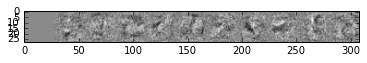

In [269]:
        image = np.zeros((28,28))
        for i in xrange(0,10):
            temp = w1[i].reshape(28,28)
            image = np.concatenate((image,temp), axis=1)
        img_plt = plt.imshow(image, cmap='gray')
        plt.show(img_plt)

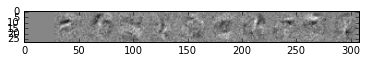

In [270]:
        image = np.zeros((28,28))
        for i in xrange(10,20):
            temp = w1[i].reshape(28,28)
            image = np.concatenate((image,temp), axis=1)
        img_plt = plt.imshow(image, cmap='gray')
        plt.show(img_plt)

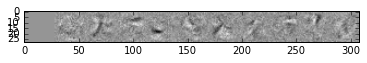

In [271]:
        image = np.zeros((28,28))
        for i in xrange(20,30):
            temp = w1[i].reshape(28,28)
            image = np.concatenate((image,temp), axis=1)
        img_plt = plt.imshow(image, cmap='gray')
        plt.show(img_plt)

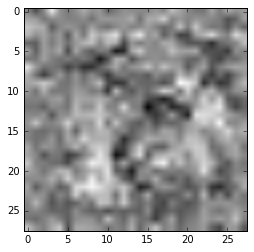

In [272]:
image = w1[9].reshape(28,28)
img_plt = plt.imshow(image, cmap='gray')
plt.show(img_plt)

<h3>Visual Check for test images and predicted labels</h3>

In [273]:
def draw_image(x, y, title_str, drawTest = False):
    for c in range(1, 10):
        plt.subplot(3, 3,c)
        i = np.random.randint(x.shape[0]) 
        predicted, real = predict(x[i], y[i], w1, w2, b1, b2)
        im = testingImages[i].reshape((28,28)) 
        plt.axis("off")
        label = predicted
        plt.title("{} = {}".format(title_str, label))
        plt.imshow(im, cmap='gray')

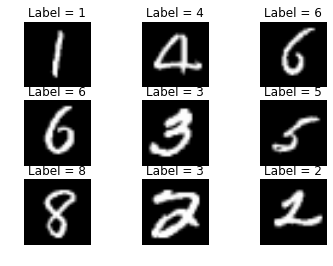

In [274]:
draw_image(testingImages, testingLabels, "Label")